In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# read csv as data frame 
df = pd.read_csv("data.csv")

print(df.shape)

(12684, 26)


# PreProcessing

## Redundant Features

In [3]:
# drop cars as it is mostly blank (108 are blank, 12576 are empty)
df = df.drop(columns=['car'])

# drop direction_opp as it is inverse of direction_same so its redundant
df = df.drop(columns=['direction_opp'])

## Blanks and Duplicates

In [4]:
# print number of duplicates
print("num duplicates", df.duplicated().sum())

# print number of null in each colmn
df.isnull().sum()

num duplicates 74


destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
Y                         0
dtype: int64

### Summary of blanks and duplicates
|Feature|Number of blanks|
|------|----------------|
|bar|107|
|CoffeeHouse|217|
|CarryAway|151|
|RestaurantLessThan20|130|
|Restaurant20To50|189|

### Other observations
- There are 74 duplicates
- There 42 common blanks between these 5

In [5]:
# drop duplicates
df = df.drop_duplicates()

# list of columns with blank values
blank_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

# delete 42 common null values
df.dropna(subset=blank_columns, how='all', inplace=True)

# null impute based on average probalistic weightage in each of the classes
for column in blank_columns:
    weights = df[column].value_counts(normalize=True)
    df[column].fillna(pd.Series(np.random.choice(weights.index, size=len(df.index), p=weights.values.tolist())), inplace=True)

In [6]:
df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

## Encoding
| Feature  | Type of categorical data |
|-------------|-----------|
| destination | nominal   |
| passanger   | nominal   |
| weather     | nominal   |
| temperature | ordinal   |
| time        | ordinal   |
| coupon      | nominal   |
| expiration  | ordinal   |
| gender      | nominal   |
| age         | ordinal   |
| maritalStatus | nominal |
| has_children | encoded  |
| education   | ordinal   |
| occupation  | nominal   |
| income      | ordinal   |
| Bar         | ordinal   |
| CoffeeHouse | ordinal   |
| CarryAway   | ordinal   |
| RestaurantLessThan20 | ordinal |
| Restaurant20To50 | ordinal |
| toCoupon_GEQ5min | encoded |
| toCoupon_GEQ15min | encoded |
| toCoupon_GEQ25min | encoded |
| direction_opp | encoded  |

In [7]:
# Ordinal Encoding

# the order of the categories in the ordinal columns that have data related to amount visited
amount_visited_order = ['never','less1','1~3','4~8','gt8']

# ordinal columns with their categories in order
ordinal_columns = [('temperature',['30','55','80']), 
                   ('time', ['7AM', '10AM', '2PM', '6PM', '10PM']), 
                   ('expiration', ['2h', '1d']),
                   ('gender', ['Male', 'Female']), # since its 2 values we can do ordinal encoding
                   ('age', ['below21','21','26','31','36','41','46','50plus']), 
                   ('education', ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)']),
                   ('income', ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More']),
                   ('Bar', amount_visited_order),
                   ('CoffeeHouse', amount_visited_order),
                   ('CarryAway', amount_visited_order),
                   ('RestaurantLessThan20', amount_visited_order),
                   ('Restaurant20To50', amount_visited_order)]

# apply the ordinal encoding
for column, categories in ordinal_columns:
    df[column] =  OrdinalEncoder(categories=[categories], dtype=np.uint8).fit_transform(df[[column]])

In [8]:
# Nominal Encoding

nomimal_columns = ['destination', 'passanger', 'weather', 'coupon', 'maritalStatus', 'occupation']

for column in nomimal_columns:
    df = pd.get_dummies(df, columns=[column])


# Classification

In [9]:
# for machine learning, we need arrays so we extract y as array
y = df["Y"].to_numpy()

# extract features as array for machine learning
x = df.drop(columns=["Y"]).to_numpy()

In [10]:
def plot_auc(fpr: np.ndarray, tpr: np.ndarray, roc_auc: np.float16) -> None:
    """
    Plot the Receiver Operating Characteristic (ROC) curve.

    Parameters:
    fpr (np.ndarray): Array of false positive rates.
    tpr (np.ndarray): Array of true positive rates.
    roc_auc (float): Area under the ROC curve.

    Returns:
    None
    """
    plt.figure(figsize=(4, 4))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_matrix: np.ndarray) -> None:
    """
    Plot the confusion matrix.

    Parameters:
    conf_matrix (np.ndarray): The confusion matrix.

    Returns:
    None
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(conf_matrix))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    # Display raw values in the confusion matrix
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def round(num) -> str:
    """
    Round a number to 3 decimal places for printing

    Parameters:
    x (float): The number to be rounded.

    Returns:
    str: The rounded number as a string.

    """
    return str(float("{:.3f}".format(num))).ljust(5, '0')


def get_cross_validated_metrics(clf: BaseEstimator, x: np.ndarray) -> None:
    """
    Calculate and display various evaluation metrics for a classifier using cross-validation.
    The metrics calculated are: accuracy, F1-score, precision, recall, AUC and confusion matrix.

    Parameters:
    clf (BaseEstimator): The classifier model.
    x (np.ndarray): The input features for the classifier.

    Returns:
    None
    """

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    acc_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    conf_matrices = []

    # Do 5-fold cross validation
    for train, test in KFold(n_splits=5).split(x, y):
        clf.fit(x[train], y[train])
        probas_ = clf.predict_proba(x[test])
        preds = clf.predict(x[test])
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        # Compute accuracy, F1-score, precision and recall for each class
        acc_scores.append(accuracy_score(y[test], preds))
        f1_scores.append(f1_score(y[test], preds, average=None))
        precision_scores.append(precision_score(y[test], preds, average=None))
        recall_scores.append(recall_score(y[test], preds, average=None))
        
        # Compute confusion matrix
        conf_matrices.append(confusion_matrix(y[test], preds))

    # Calculate averages for each class
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_acc = np.mean(acc_scores)
    mean_f1 = np.mean(f1_scores, axis=0)
    mean_precision = np.mean(precision_scores, axis=0)
    mean_recall = np.mean(recall_scores, axis=0)
    mean_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)

    # print results (for positive class only)
    print("Accuracy:\t", round(mean_acc))
    print("F1-score:\t", round(mean_f1[1]))
    print("Precision:\t", round(mean_precision[1]))
    print("Recall:\t\t", round(mean_recall[1]))
    print("AUC:\t\t", round(mean_auc))

    # plot AUC
    plot_auc(mean_fpr, mean_tpr, mean_auc)

    # plot confusion matrix
    plot_confusion_matrix(mean_conf_matrix)

## Decision Tree

Accuracy:	 0.679
F1-score:	 0.730
Precision:	 0.699
Recall:		 0.767
AUC:		 0.723


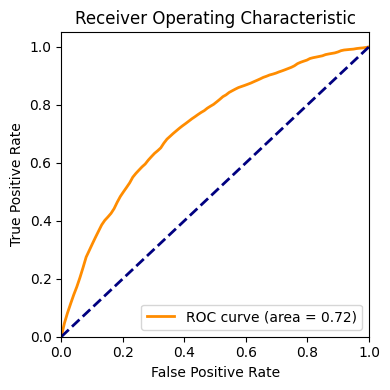

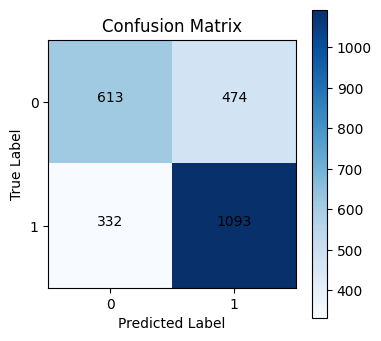

In [11]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=210, ccp_alpha=0.00031)
get_cross_validated_metrics(dtc, x)

### With Feature Selection

Accuracy:	 0.686
F1-score:	 0.738
Precision:	 0.699
Recall:		 0.784
AUC:		 0.730


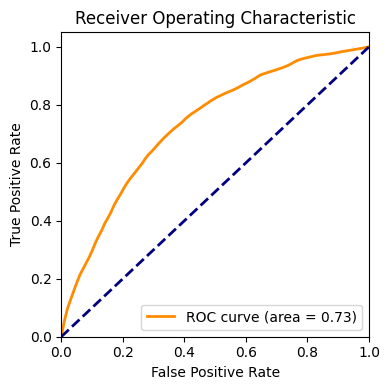

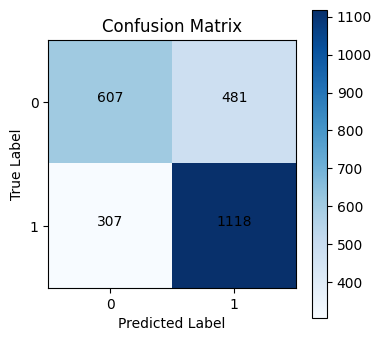

In [12]:
x_new = SelectKBest(chi2, k=11).fit_transform(x, y)
get_cross_validated_metrics(dtc, x_new)

## Naive Bayes

Accuracy:	 0.655
F1-score:	 0.708
Precision:	 0.678
Recall:		 0.745
AUC:		 0.688


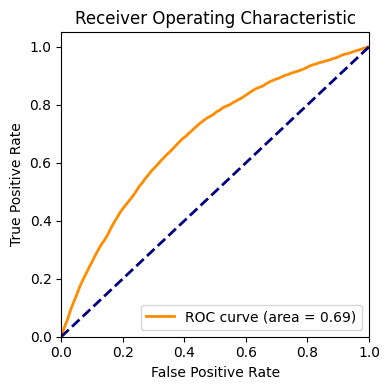

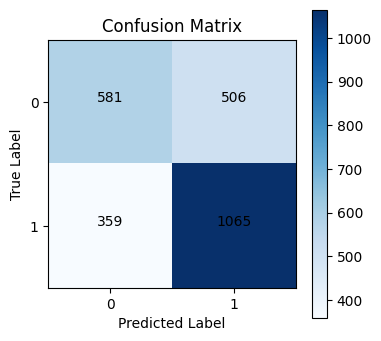

In [13]:
gnb = GaussianNB(var_smoothing=0.012)
get_cross_validated_metrics(gnb, x)

### With Dimentionality Reduction

Accuracy:	 0.659
F1-score:	 0.723
Precision:	 0.669
Recall:		 0.787
AUC:		 0.702


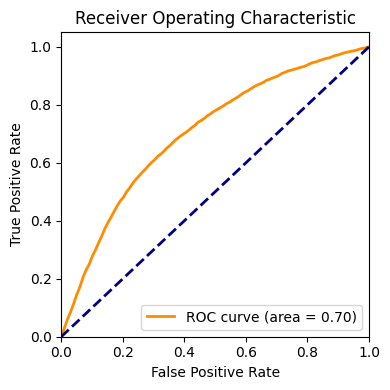

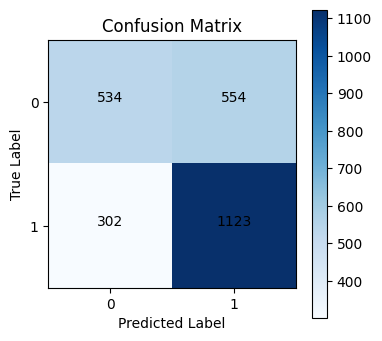

In [14]:
x_new = PCA(n_components=26).fit_transform(x) 
get_cross_validated_metrics(gnb, x_new)

## KNN

Accuracy:	 0.640
F1-score:	 0.712
Precision:	 0.650
Recall:		 0.788
AUC:		 0.676


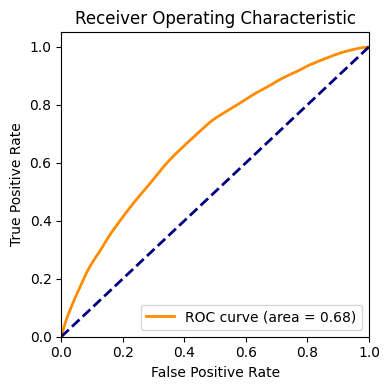

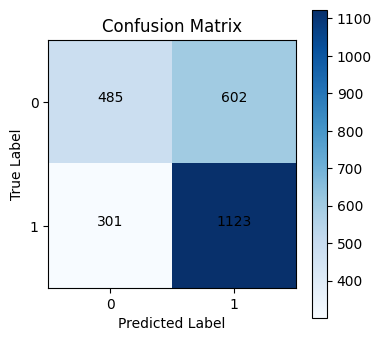

In [15]:
knn = KNeighborsClassifier(n_neighbors=46, n_jobs=-1)
get_cross_validated_metrics(knn, x)

### With Feature Selection

Accuracy:	 0.686
F1-score:	 0.736
Precision:	 0.702
Recall:		 0.775
AUC:		 0.729


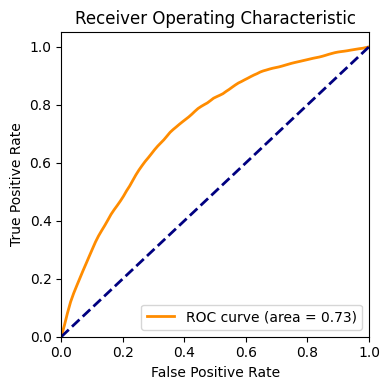

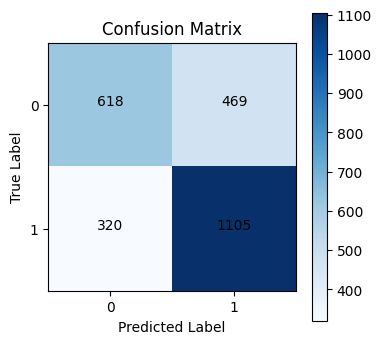

In [16]:
x_new = SelectKBest(score_func=chi2, k=11).fit_transform(x, y)
get_cross_validated_metrics(knn, x_new)

## SVM

Accuracy:	 0.691
F1-score:	 0.740
Precision:	 0.705
Recall:		 0.780
AUC:		 0.745


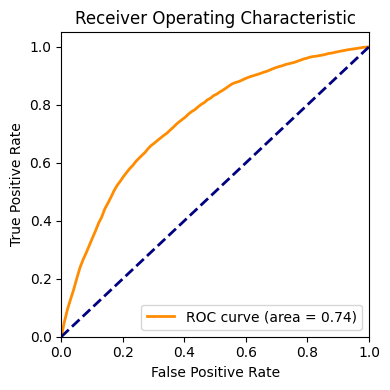

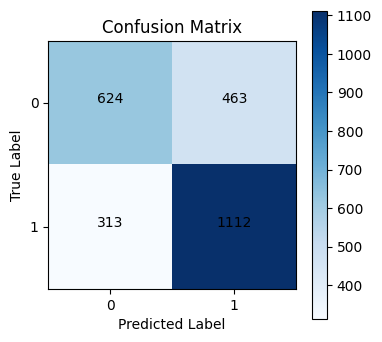

In [17]:
svm = SVC(C=1, gamma=0.1, kernel='rbf', probability=True)
get_cross_validated_metrics(svm, x)

### With Feature Selection

Accuracy:	 0.701
F1-score:	 0.749
Precision:	 0.714
Recall:		 0.789
AUC:		 0.743


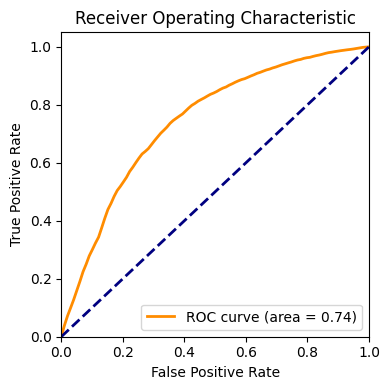

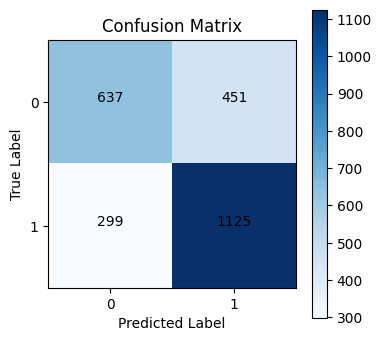

In [18]:
x_new = SelectKBest(score_func=chi2, k=19).fit_transform(x, y)
get_cross_validated_metrics(svm, x_new)

## Random Forest

Accuracy:	 0.704
F1-score:	 0.754
Precision:	 0.710
Recall:		 0.805
AUC:		 0.757


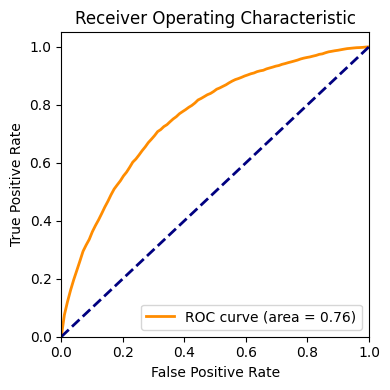

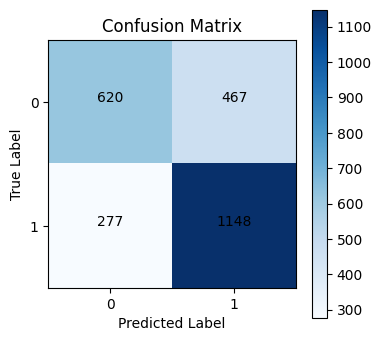

In [19]:
rf = RandomForestClassifier(ccp_alpha= 0.0003, n_jobs=-1)
get_cross_validated_metrics(rf, x)